In [131]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

# feature selection
from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectKBest, f_classif

# model selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [3]:
filenames = [f for f in os.listdir('../data')]
print(filenames)

['ucs.csv', 'chol.csv', 'stad.csv', 'kich.csv', 'ucec.csv', 'brca.csv', 'ov.csv', 'skcm.csv', 'meso.csv', 'dlbc.csv', 'read.csv', 'paad.csv', 'thca.csv', 'blca.csv', 'thym.csv', 'kirc.csv', 'kirp.csv', 'coad.csv', 'gbm.csv', 'lihc.csv', 'data.csv', 'prad.csv', 'lgg.csv', 'sarc.csv', 'acc.csv', 'luad.csv', 'esca.csv', 'hnsc.csv', 'uvm.csv', 'lusc.csv', 'pcpg.csv', 'tgct.csv', 'cesc.csv', 'laml.csv']


In [4]:
pan_cancer_df = pd.DataFrame()

# Cancer types
# cancers = [f for f in os.listdir('../data') if os.path.isfile(os.path.join('../data', f))]

cancers = ['kich', 'acc', 'blca', 'brca', 'cesc', 'esca', 'laml', 'lgg', 'ov', 'paad', 'prad', 'read', 'tgct', 'thca', 'luad', 'ucec', 'coad', 'skcm']

# Import data
# 100%
for cancer in cancers:
  data = pd.read_csv(f'../data/{cancer}.csv')
  data['project_id'] = cancer.upper()
  pan_cancer_df = pd.concat([pan_cancer_df, data], ignore_index=True)

In [5]:
# Dataframe info
pan_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308359 entries, 0 to 2308358
Data columns (total 37 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   #"chrom"                     object 
 1   chromStart                   int64  
 2   chromEnd                     int64  
 3   name                         object 
 4   score                        int64  
 5   strand                       object 
 6   thickStart                   int64  
 7   thickEnd                     int64  
 8   reserved                     object 
 9   blockCount                   int64  
 10  blockSizes                   int64  
 11  chromStarts                  int64  
 12  sampleCount                  int64  
 13  freq                         float64
 14  Hugo_Symbol                  object 
 15  Entrez_Gene_Id               int64  
 16  Variant_Classification       object 
 17  Variant_Type                 object 
 18  Reference_Allele             object 
 19  

**Type cast column**

In [6]:
# Typecast numeric columns to int32 for memory optimization
numeric_columns = pan_cancer_df.select_dtypes(exclude=[object, float]).columns
pan_cancer_df[numeric_columns] = pan_cancer_df[numeric_columns].astype('int32')

**Rename column**

In [7]:
# Columns to lowercase
pan_cancer_df.columns = pan_cancer_df.columns.str.lower()

# Rename columns
pan_cancer_df.rename(columns={'#"chrom"':'chrom', 'project_id':'cancer_type', 'variant_classification':'variant', 'matched_norm_sample_barcode':'barcode'}, inplace=True)

**Split record**

In [8]:
# Specify the columns to split
columns_to_split = ['days_to_death', 'cigarettes_per_day', 'weight', 'alcohol_history', 'alcohol_intensity', 'bmi', 'years_smoked', 'height', 'gender', 'ethnicity', 'tumor_sample_barcode', 'barcode', 'case_id']

# Convert columns to strings and then split values
pan_cancer_df.loc[:, columns_to_split] = pan_cancer_df[columns_to_split].astype(str).apply(lambda x: x.str.split(','))

# Explode the specified columns and reset the index
pan_cancer_df = pan_cancer_df.explode(columns_to_split).reset_index(drop=True)

**handle null and missing values**

In [9]:
# Raw data has null values with dashes '--'
pan_cancer_df.head(1)

# Replace '--' with nan
pan_cancer_df.replace('--', np.nan, inplace=True)
pan_cancer_df.head(1)

/var/folders/m1/k07dlfws1fq68r62wllwpqrh0000gn/T/ipykernel_46310/2086964454.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pan_cancer_df.replace('--', np.nan, inplace=True)


,chrom,chromstart,chromend,name,score,strand,thickstart,thickend,reserved,blockcount,...,alcohol_intensity,bmi,years_smoked,height,gender,cancer_type,ethnicity,tumor_sample_barcode,barcode,case_id
0,chr1,1049635,1049636,C>T,1,.,1049635,1049636,"0,0,0",1,...,NaN,NaN,NaN,NaN,male,KICH,not hispanic or latino,TCGA-KN-8428-01A-11D-2310-10,TCGA-KN-8428-11A-01D-2311-10,455fd7d4-5ff4-423f-83ce-4630aef89bb7


In [10]:
# Check missing values
pan_cancer_df.isnull().sum()

chrom                         0
chromstart                    0
chromend                      0
name                          0
score                         0
strand                        0
thickstart                    0
thickend                      0
reserved                      0
blockcount                    0
blocksizes                    0
chromstarts                   0
samplecount                   0
freq                          0
hugo_symbol                   0
entrez_gene_id                0
variant                       0
variant_type                  0
reference_allele              0
tumor_seq_allele1             0
tumor_seq_allele2             0
dbsnp_rs                 709762
dbsnp_val_status        2084489
days_to_death           1854276
cigarettes_per_day      2129638
weight                   935547
alcohol_history         2347275
alcohol_intensity       2420700
bmi                      981195
years_smoked            2347211
height                   959046
gender  

In [11]:
# Drop based on null values
pan_cancer_df.drop(columns=['dbsnp_rs', 'dbsnp_val_status', 'days_to_death', 'cigarettes_per_day', 'weight', 'alcohol_history', 'alcohol_intensity', 'years_smoked', 'height', 'ethnicity', 'bmi'], inplace=True)

# Drop based on insignificance
pan_cancer_df.drop(columns=['case_id', 'reserved', 'blockcount', 'score', 'strand', 'chromstarts', 'samplecount', 'tumor_sample_barcode', 'entrez_gene_id'], inplace=True)

In [12]:
# Calculate the distribution of existing gender values
gender_distribution = pan_cancer_df['gender'].value_counts(normalize=True)

# Create a mask for null gender values
null_mask = pan_cancer_df['gender'].isnull()

# Fill null gender values with random genders based on the distribution
random_genders = np.random.choice(gender_distribution.index, size=null_mask.sum(), p=gender_distribution.values)
pan_cancer_df.loc[null_mask, 'gender'] = random_genders

# Check nulls after handling missing values
pan_cancer_df.isnull().sum()

chrom                0
chromstart           0
chromend             0
name                 0
thickstart           0
thickend             0
blocksizes           0
freq                 0
hugo_symbol          0
variant              0
variant_type         0
reference_allele     0
tumor_seq_allele1    0
tumor_seq_allele2    0
gender               0
cancer_type          0
barcode              0
dtype: int64

**Total number of patient**

In [13]:
pan_cancer_df['barcode'].nunique()

6433

In [14]:
pan_cancer_df['cancer_type'].nunique()

18

/var/folders/m1/k07dlfws1fq68r62wllwpqrh0000gn/T/ipykernel_46310/3787136172.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancer_counts.values, y=cancer_counts.index, orient='h', palette='viridis')


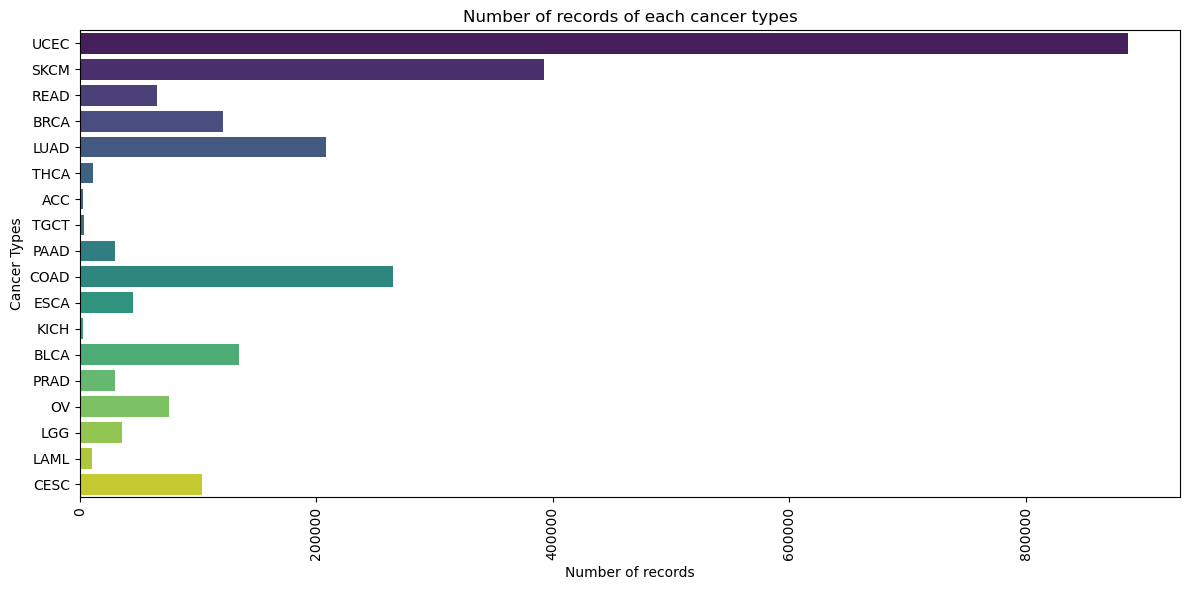

In [15]:
# Data of each cancer type
cancer_counts = pan_cancer_df['cancer_type'].value_counts().sample(frac=1, random_state=42)

# Graph of number of records of each cancer types
plt.figure(figsize=(12, 6))
sns.barplot(x=cancer_counts.values, y=cancer_counts.index, orient='h', palette='viridis')
plt.xlabel('Number of records')
plt.ylabel('Cancer Types')
plt.title('Number of records of each cancer types')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Number of patients of each cancer type.**

/var/folders/m1/k07dlfws1fq68r62wllwpqrh0000gn/T/ipykernel_46310/90760965.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancer_patient_counts.index, y=cancer_patient_counts.values, palette='husl')


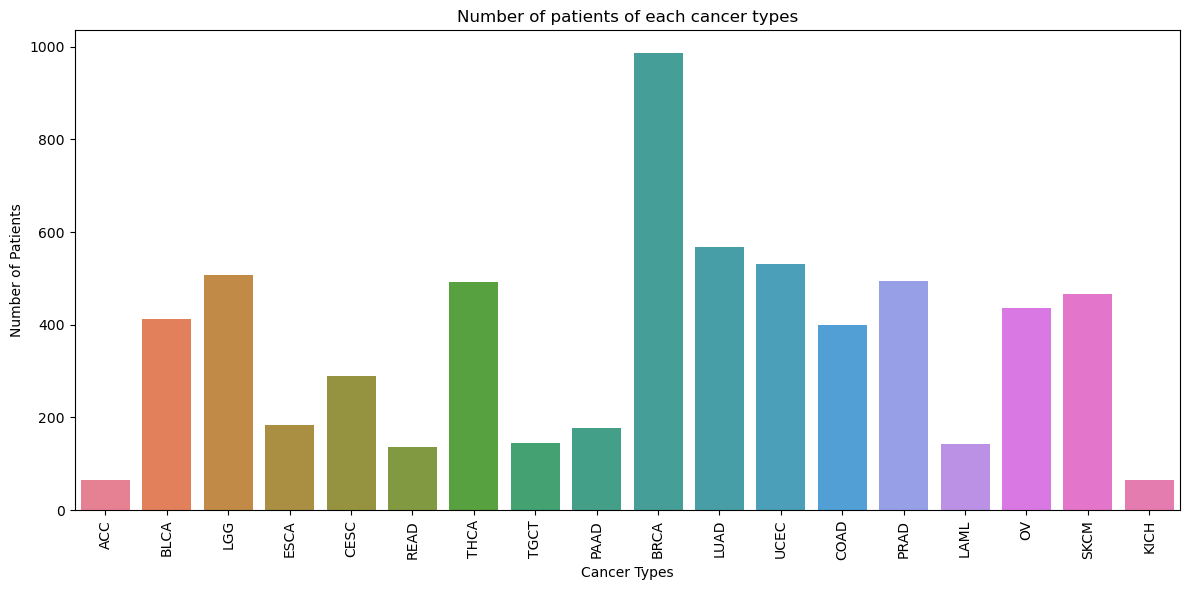

In [16]:
# Patients of each cancer type
cancer_patient_counts = pan_cancer_df.groupby('cancer_type')['barcode'].nunique().sample(frac=1, random_state=42) #.sort_values(ascending=False)

# Graph of number of patients of each cancer types
plt.figure(figsize=(12, 6))
sns.barplot(x=cancer_patient_counts.index, y=cancer_patient_counts.values, palette='husl')
plt.xlabel('Cancer Types')
plt.ylabel('Number of Patients')
plt.title('Number of patients of each cancer types')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Total variant**

/var/folders/m1/k07dlfws1fq68r62wllwpqrh0000gn/T/ipykernel_46310/1150743759.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variant_counts.values, y=variant_counts.index, orient='h', palette='flare')


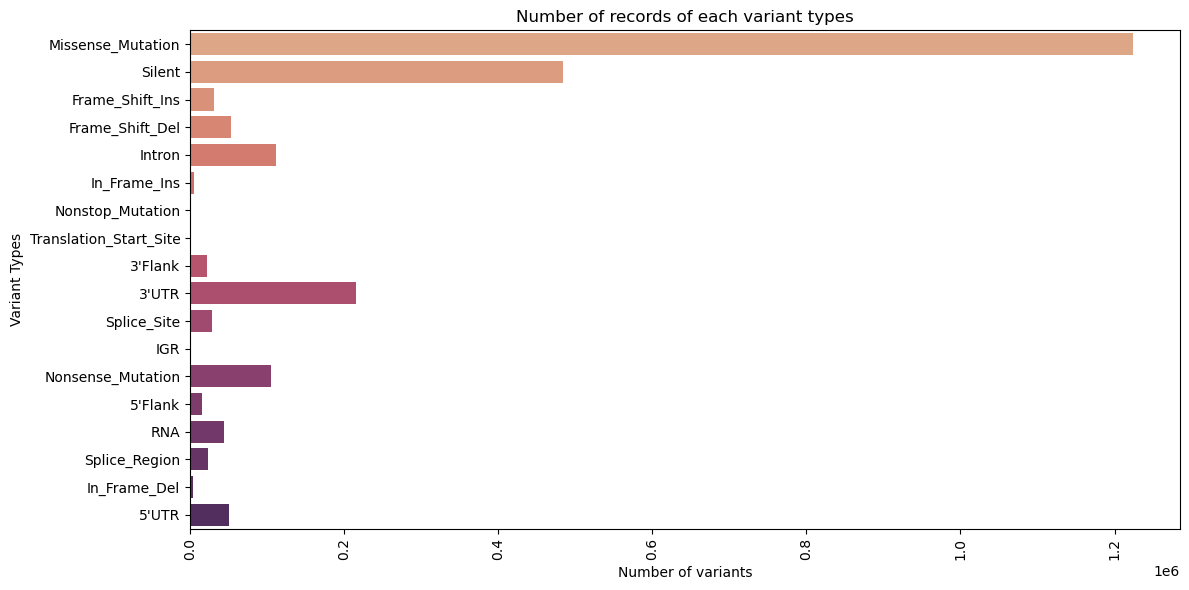

In [17]:
# Total variants
variant_counts = pan_cancer_df['variant'].value_counts().sample(frac=1, random_state=42)

# Graph of variant counts
plt.figure(figsize=(12, 6))
sns.barplot(x=variant_counts.values, y=variant_counts.index, orient='h', palette='flare')
plt.xlabel('Number of variants')
plt.ylabel('Variant Types')
plt.title('Number of records of each variant types')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Different types of chroms in the cancer dataset.**

/var/folders/m1/k07dlfws1fq68r62wllwpqrh0000gn/T/ipykernel_46310/4280028516.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=chrom_counts.index, y=chrom_counts.values, palette='crest')


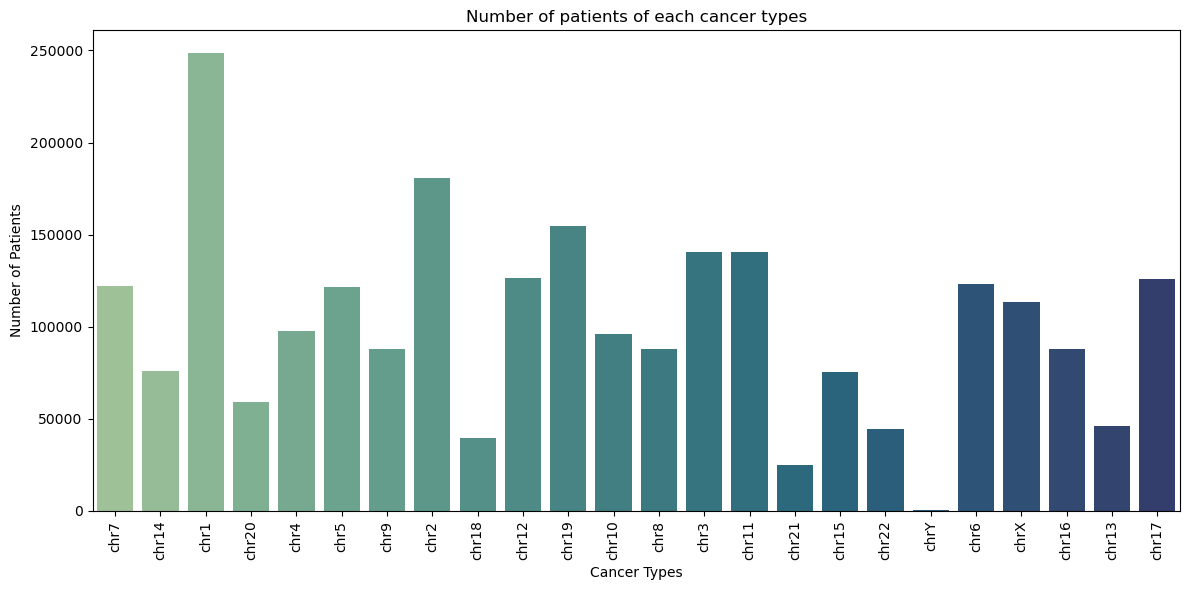

In [18]:
# Chrom counts
chrom_counts = pan_cancer_df['chrom'].value_counts().sample(frac=1, random_state=42)

# Graph of number of patients of each cancer types
plt.figure(figsize=(12, 6))
sns.barplot(x=chrom_counts.index, y=chrom_counts.values, palette='crest')
plt.xlabel('Cancer Types')
plt.ylabel('Number of Patients')
plt.title('Number of patients of each cancer types')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Different variant types available.**

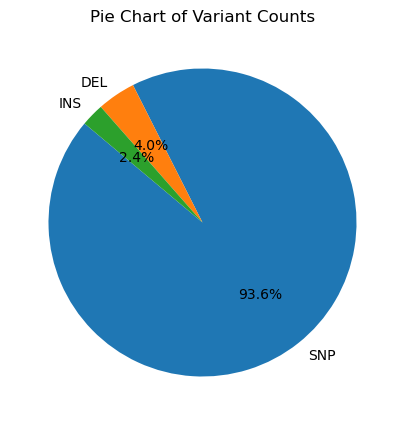

In [19]:
# Variant type counts
variant_type_counts = pan_cancer_df['variant_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(variant_type_counts, labels=variant_type_counts.index, autopct='%1.1f%%', startangle=140)

# Add a title (optional)
plt.title('Pie Chart of Variant Counts')

# Show the plot
plt.show()

**Gender distribution of the cancer data.**

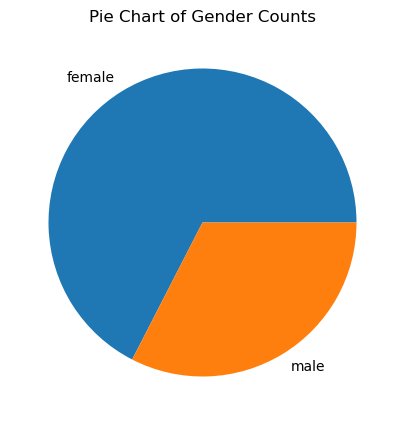

In [20]:
# Gender distribution
gender_counts = pan_cancer_df['gender'].value_counts()

# Create a pie chart
plt.figure(figsize=(5,5))
plt.pie(gender_counts, labels=gender_counts.index)

# Add a title (optional)
plt.title('Pie Chart of Gender Counts')

# Show the plot
plt.show()

### Label Encoding

In [21]:
# Label encoding
le = LabelEncoder()

# Iterate through columns and apply label encoding
for column in pan_cancer_df.columns:
    if pan_cancer_df[column].dtype == 'object':
        pan_cancer_df[column] = le.fit_transform(pan_cancer_df[column])

class_labels = {i: label for i, label in enumerate(le.classes_)}
pan_cancer_df.head()

,chrom,chromstart,chromend,name,thickstart,thickend,blocksizes,freq,hugo_symbol,variant,variant_type,reference_allele,tumor_seq_allele1,tumor_seq_allele2,gender,cancer_type,barcode
0,0,1049635,1049636,5,1049635,1049636,1,0.015152,687,10,2,2193,2193,14020,1,6,5411
1,0,1287957,1287958,6,1287957,1287958,1,0.015152,16722,10,2,4837,4837,1,1,6,5422
2,0,1332660,1332661,5,1332660,1332661,1,0.015152,18722,10,2,2193,2193,14020,1,6,5425
3,0,1440273,1440274,6,1440273,1440274,1,0.015152,20774,1,2,4837,4837,1,0,6,5417
4,0,1440294,1440295,5,1440294,1440295,1,0.015152,20774,1,2,2193,2193,14020,1,6,5429


**correlation matrix**

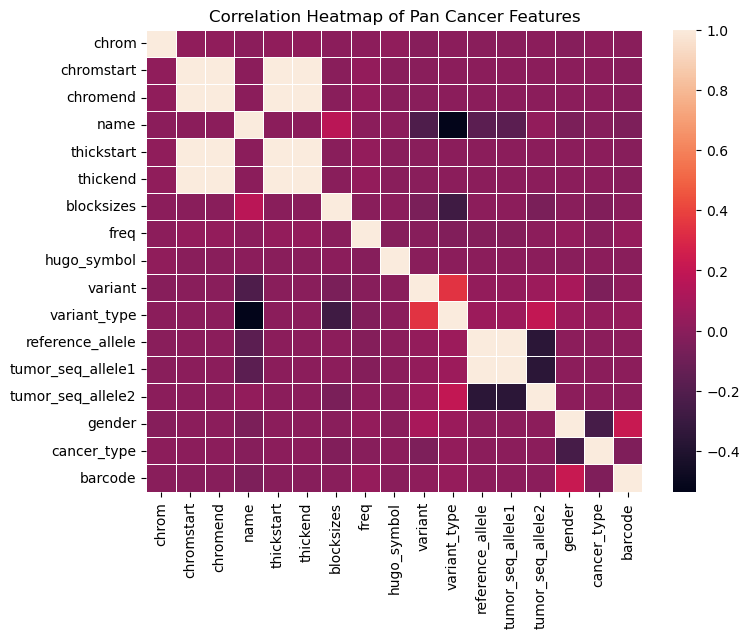

In [23]:
# Correlation of 'cancer_type' with all features
pan_cancer_df.corr()['cancer_type']

# Create the heatmap using the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pan_cancer_df.corr(), linewidths=0.5)
plt.title('Correlation Heatmap of Pan Cancer Features')
plt.show()

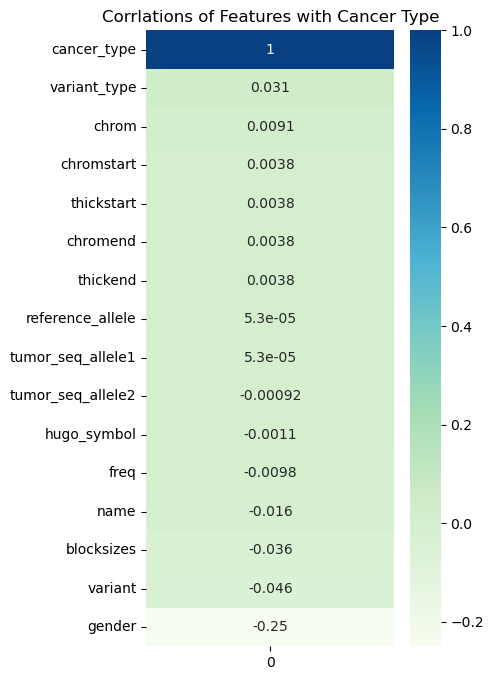

In [ ]:
corr_with_target = pan_cancer_df.corrwith(pan_cancer_df['cancer_type']).sort_values(ascending=False)
plt.figure(figsize=(4, 8))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='GnBu')
plt.title('Corrlations of Features with Cancer Type')
plt.show()

### Feature selection

In [25]:
pan_cancer_df.columns

Index(['chrom', 'chromstart', 'chromend', 'name', 'thickstart', 'thickend',
       'blocksizes', 'freq', 'hugo_symbol', 'variant', 'variant_type',
       'reference_allele', 'tumor_seq_allele1', 'tumor_seq_allele2', 'gender',
       'cancer_type', 'barcode'],
      dtype='object')

In [ ]:
# Select required features
selected_features = [
    'chrom', 
    'chromstart',
    'chromend',
    'name',
    'thickstart',
    'thickend',
    'blocksizes',
    'freq',
    'variant',
    'hugo_symbol',
    'variant_type',
    'reference_allele',
    'tumor_seq_allele1',
    'tumor_seq_allele2',
    'gender',
    'cancer_type'
]

pan_cancer_df = pan_cancer_df[selected_features]
pan_cancer_df.head()

,chrom,chromstart,chromend,name,thickstart,thickend,blocksizes,freq,variant,hugo_symbol,variant_type,reference_allele,tumor_seq_allele1,tumor_seq_allele2,gender,cancer_type
0,0,1049635,1049636,5,1049635,1049636,1,0.015152,10,687,2,2193,2193,14020,1,6
1,0,1287957,1287958,6,1287957,1287958,1,0.015152,10,16722,2,4837,4837,1,1,6
2,0,1332660,1332661,5,1332660,1332661,1,0.015152,10,18722,2,2193,2193,14020,1,6
3,0,1440273,1440274,6,1440273,1440274,1,0.015152,1,20774,2,4837,4837,1,0,6
4,0,1440294,1440295,5,1440294,1440295,1,0.015152,1,20774,2,2193,2193,14020,1,6


**split data**

In [122]:
# Split data into dependent/independent variables
X = pan_cancer_df.iloc[:, :-1].values
y = pan_cancer_df.iloc[:, -1].values

# X_new = SelectKBest(f_classif, k=10).fit_transform(X, y)

# Test/Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train.shape, X_test.shape

((1936560, 15), (484140, 15))

### Train model

**RandomForestClassifier**

In [123]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

**select important features**

15


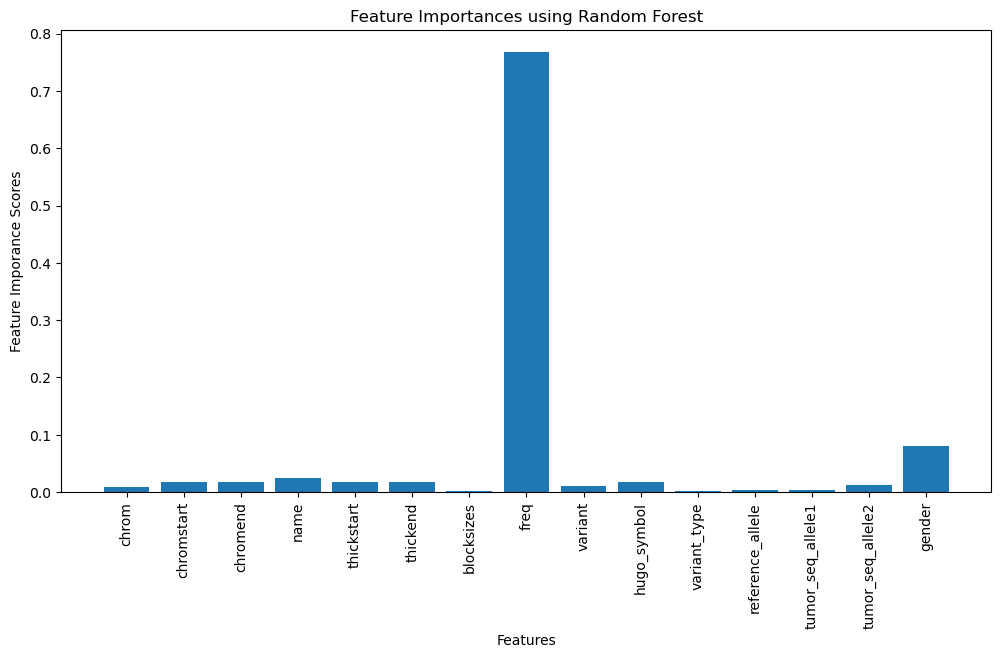

In [ ]:
importances = rf_classifier.feature_importances_
print(len(importances))
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), pan_cancer_df.columns[:-1], rotation=90)
plt.ylabel('Feature Imporance Scores')
plt.xlabel('Features')
plt.title('Feature Importances using Random Forest')
plt.show()

**Cross validation**

In [ ]:
# Cross validation
def cross_val(model, X_train, X_test, y_train, n_splits=5):
  oofs = np.zeros(len(X_train))
  preds = np.zeros(len(X_test))

  target_col = pd.DataFrame(data=y_train)

  folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
  stratified_target = pd.qcut(y_train, 10, labels=False, duplicates='drop')

  for index, (trn_idx, val_idx) in enumerate(folds.split(X_train, stratified_target)):
    print(f'\n=============================== Fold {index + 1} ==================================')

    cv_X_train, cv_y_train = X_train[trn_idx], target_col.iloc[trn_idx]
    cv_X_val, cv_y_val = X_train[val_idx], target_col.iloc[val_idx]

    model.fit(cv_X_train, cv_y_train)

    val_preds = model.predict(cv_X_val)
    test_preds = model.predict(X_test)

    error = precision_score(cv_y_val, val_preds, average='macro')
    print(f'Precision is : {error}')

    oofs[val_idx] = val_preds
    preds += test_preds/n_splits

  total_error = precision_score(target_col, oofs, average='macro')
  print(f'\n Precision is {total_error}')

  return oofs, preds

### XGBoost Classifier

In [114]:
# XGBoost Classifier
xgb_classifier = XGBClassifier(objective="multi:softmax", num_classes=pan_cancer_df['cancer_type'].nunique(), n_estimators=10, random_state=42)

# Cross validation
xgb_oofs, xgb_pred = cross_val(xgb_classifier, X_train, X_test, y_train, 5)


================================ Fold 1 ===================================


/Users/macgeargear/miniconda3/envs/bioinfo-project/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:54:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Precision is : 0.9300108223759188

================================ Fold 2 ===================================


/Users/macgeargear/miniconda3/envs/bioinfo-project/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:54:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Precision is : 0.9338543286949995

================================ Fold 3 ===================================


/Users/macgeargear/miniconda3/envs/bioinfo-project/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:54:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Precision is : 0.929853635361422

================================ Fold 4 ===================================


/Users/macgeargear/miniconda3/envs/bioinfo-project/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:54:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Precision is : 0.9279594058555239

================================ Fold 5 ===================================


/Users/macgeargear/miniconda3/envs/bioinfo-project/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:54:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Precision is : 0.9313869621490153

 Precision is 0.9306524907694393


**Predict**

In [124]:
# Random Forest
rf_pred = rf_classifier.predict(X_test)

# XGBoost
xgb_pred = list(map(int, xgb_pred))

### Evaluation

**Accuracy**

In [125]:
# Random Forest
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")

# XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Classifier Accuracy: {xgb_accuracy:.4f}")

Random Forest Classifier Accuracy: 0.9816
XGBoost Classifier Accuracy: 0.9953


**Precision**

In [126]:
# Random Forest
rf_precision = precision_score(rf_pred, y_test, average='macro')
print(f"Random Forest Classifier Precision: {rf_precision:.4f}")

# XGBoost
xgb_precision = precision_score(xgb_pred, y_test, average='macro')
print(f"Random Forest Classifier Precision: {xgb_precision:.4f}")

Random Forest Classifier Precision: 0.7878
Random Forest Classifier Precision: 0.8883


In [127]:
# XGBoost Classifier
xgb_report = classification_report(y_test, xgb_pred)
print("\nXGBoost Classifier Classification Report:\n")
print(xgb_report)


XGBoost Classifier Classification Report:

              precision    recall  f1-score   support

           0       0.14      0.02      0.03       579
           1       0.99      1.00      1.00     26903
           2       0.99      1.00      0.99     24198
           3       0.99      1.00      0.99     20681
           4       0.99      0.99      0.99     52957
           5       1.00      1.00      1.00      9063
           6       0.15      0.03      0.05       579
           7       1.00      0.99      1.00      1981
           8       1.00      0.99      1.00      7111
           9       1.00      1.00      1.00     41636
          10       1.00      1.00      1.00     15033
          11       1.00      1.00      1.00      5992
          12       1.00      1.00      1.00      5857
          13       1.00      1.00      1.00     12961
          14       1.00      1.00      1.00     78514
          15       0.98      0.99      0.98       640
          16       1.00      0.99    

**F1 Score**

In [128]:
# XGBoost Classifier
xgb_report = classification_report(y_test, xgb_pred)
print("\nXGBoost Classifier Classification Report:\n")
print(xgb_report)


XGBoost Classifier Classification Report:

              precision    recall  f1-score   support

           0       0.14      0.02      0.03       579
           1       0.99      1.00      1.00     26903
           2       0.99      1.00      0.99     24198
           3       0.99      1.00      0.99     20681
           4       0.99      0.99      0.99     52957
           5       1.00      1.00      1.00      9063
           6       0.15      0.03      0.05       579
           7       1.00      0.99      1.00      1981
           8       1.00      0.99      1.00      7111
           9       1.00      1.00      1.00     41636
          10       1.00      1.00      1.00     15033
          11       1.00      1.00      1.00      5992
          12       1.00      1.00      1.00      5857
          13       1.00      1.00      1.00     12961
          14       1.00      1.00      1.00     78514
          15       0.98      0.99      0.98       640
          16       1.00      0.99    

In [130]:
xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
rf_f1 = f1_score(y_test, rf_pred, average='macro')
print(f'XGBoost Classifier F1 Score: {xgb_f1:.4f}')
print(f'Random Forest Classifier F1 Score: {rf_f1:.4f}')

XGBoost Classifier F1 Score: 0.8896
Random Forest Classifier F1 Score: 0.8033


**Confusion Matrix**

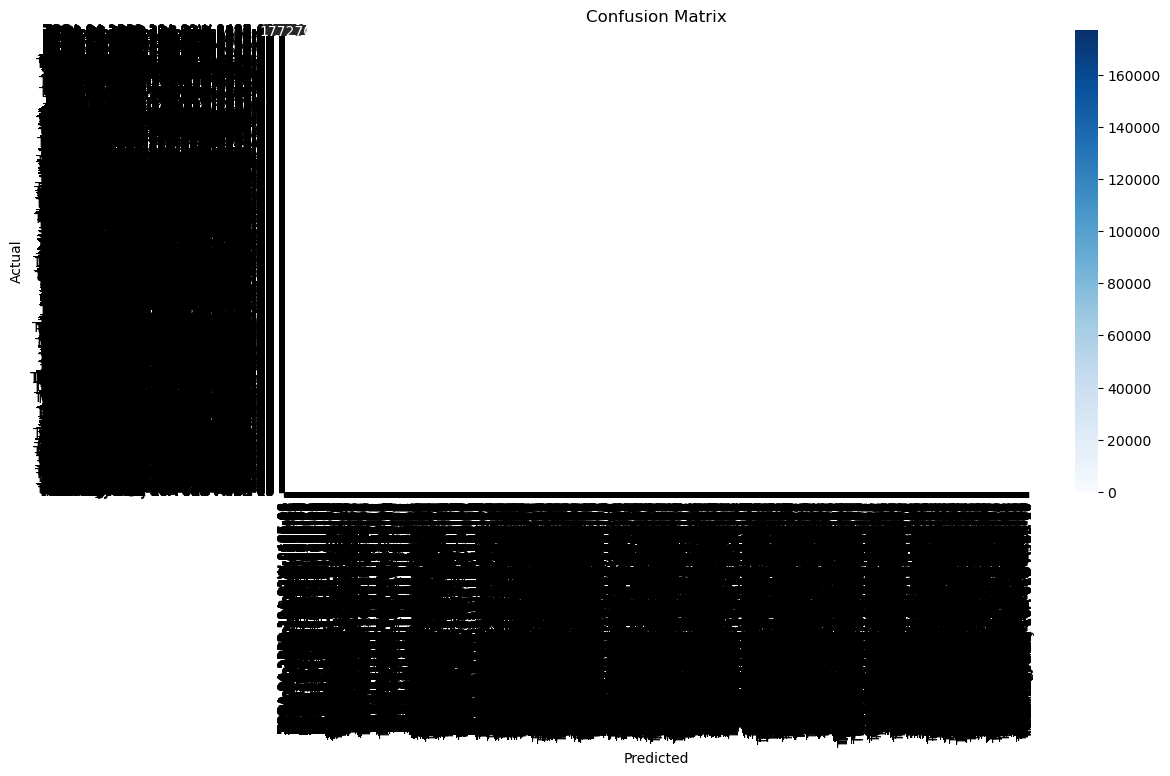

In [40]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, xgb_pred)

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### MLP Classifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

num_classes = pan_cancer_df['cancer_type'].nunique()
num_epochs = 10
input_size = pan_cancer_df.shape[1] - 1

dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print(model)

CancerPredictor(
  (fc1): Linear(in_features=15, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=18, bias=True)
)


Epoch 1, Loss: 0.6041, Accuracy: 0.8193
Epoch 2, Loss: 0.2752, Accuracy: 0.9280
Epoch 3, Loss: 0.2393, Accuracy: 0.9339
Epoch 4, Loss: 0.2204, Accuracy: 0.9365
Epoch 5, Loss: 0.2099, Accuracy: 0.9387
Epoch 6, Loss: 0.2030, Accuracy: 0.9406
Epoch 7, Loss: 0.1972, Accuracy: 0.9420
Epoch 8, Loss: 0.1943, Accuracy: 0.9428
Epoch 9, Loss: 0.1923, Accuracy: 0.9435
Epoch 10, Loss: 0.1907, Accuracy: 0.9439


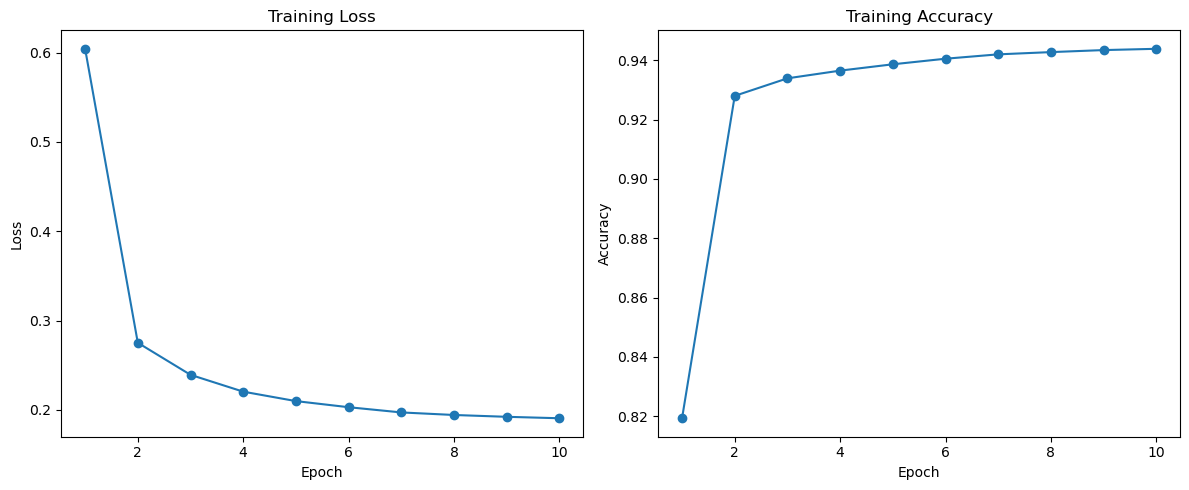

In [108]:
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    correct_preds = 0
    total_preds = 0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        epoch_loss += loss.item()
        predictions = outputs.argmax(dim=1)
        correct_preds += (predictions == labels).sum().item()
        total_preds += labels.size(0)
        
    avg_loss = epoch_loss / len(dataloader)
    avg_accuracy = correct_preds / total_preds
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

**Evaluate the model**

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(X_test).float())
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == torch.tensor(y_test)).sum().item() / len(y_test)

    y_true = torch.tensor(y_test).numpy()
    y_pred = predicted.numpy()

    accuracy = (predicted == torch.tensor(y_test)).sum().item() / len(y_test)
    f1 = f1_score(y_true, y_pred, average='weighted')  
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

Accuracy: 0.9566
F1 Score: 0.9558
Precision: 0.9571
Recall: 0.9566


### AutoEncoders

In [156]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, encode_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, encode_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encode_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [ ]:
num_classes = pan_cancer_df['cancer_type'].nunique()
num_epochs = 10
input_size = pan_cancer_df.shape[1] - 1

dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

autoencoder = Autoencoder(input_size, 128)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001) 

train_losses = []

num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, _ in dataloader:
        optimizer.zero_grad()
        _, decoded = autoencoder(inputs)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Extract features
autoencoder.eval()
with torch.no_grad():
    encoded_features, _ = autoencoder(torch.tensor(X_train).float())

In [ ]:
outputs = autoencoder(torch.tensor(X_test).float())
# predicted = torch.argmax(torch.tensor(outputs), dim=1)
accuracy = (predicted == torch.tensor(y_test)).sum().item() / len(y_test)

y_true = torch.tensor(y_test).numpy()
y_pred = predicted.numpy()

f1 = f1_score(y_true, y_pred, average='weighted')  
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

ValueError: only one element tensors can be converted to Python scalars